# Recommendation List Bayesian Analysis

This notebook analyzes the results of Bayesian inference for the recommendation lists.

## Setup

In [1]:
import sys
from pathlib import Path
from textwrap import dedent

In [2]:
import pandas as pd
import numpy as np
import zarr
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from scipy import stats
from scipy.special import expit, logit, logsumexp
from IPython.display import display, Markdown

In [3]:
import bookgender.datatools as dt
from bookgender.config import rng_seed
from lenskit.util import init_rng
from bookgender.nbutils import *

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\fastparquet\dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [4]:
fig_dir = init_figs('RecModel')

using figure dir figures\RecModel


In [5]:
seed = init_rng(rng_seed(), 'RecModelAnalysis')
rng = np.random.default_rng(seed)
seed

SeedSequence(
    entropy=261868553827208103807548308384201786360,
    spawn_key=(1943263061,),
)

## Load Data

In [6]:
datasets = list(dt.datasets.keys())

Load the profile and list data for context:

In [7]:
profiles = pd.read_pickle('data/profile-data.pkl')
rec_lists = pd.read_pickle('data/rec-data.pkl')
rec_lists.head()

ambiguous  female  male  unknown  Total  Known  PropKnown  \
Set Algorithm user                                                              
AZ  als       529           2       8    19       21     50     27       0.54   
              1723          0      12     9       29     50     21       0.42   
              1810          2       6     9       33     50     15       0.30   
              2781          1       8    17       24     50     25       0.50   
              2863          2       4    25       19     50     29       0.58   

                    PropFemale  dcknown  dcyes    PropDC  
Set Algorithm user                                        
AZ  als       529     0.296296       44     23  0.522727  
              1723    0.571429       39     17  0.435897  
              1810    0.400000       31     16  0.516129  
              2781    0.320000       35     17  0.485714  
              2863    0.137931       37     20  0.540541

In [8]:
rec_lists.groupby('Set')['Total'].count()

Set
AZ      34489
BX-E     9806
BX-I    19981
GR-E     9876
GR-I    19994
Name: Total, dtype: int64

Compute the algorithm names:

In [9]:
algo_names = rec_lists.reset_index().groupby('Set')['Algorithm'].apply(lambda x: sorted(x.unique()))
algo_names

Set
AZ      [als, bpr-imp, item-item, item-item-imp, user-...
BX-E                               [item-item, user-user]
BX-I                    [bpr, item-item, user-user, wrls]
GR-E                               [item-item, user-user]
GR-I                    [bpr, item-item, user-user, wrls]
Name: Algorithm, dtype: object

And compute rec list length / distinctness stats:

In [10]:
recs = pd.read_parquet('data/study-recs.parquet')
recs.rename(columns={'dataset': 'Set', 'algorithm': 'Algorithm'}, inplace=True)
recs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9643759 entries, 0 to 9643758
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Set        object 
 1   Algorithm  object 
 2   item       int64  
 3   score      float64
 4   user       int64  
 5   rank       int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 441.5+ MB


In [11]:
list_stats = recs.groupby(['Set', 'Algorithm'])['item'].agg(['count', 'nunique'])
list_stats['distfrac'] = list_stats['nunique'] / list_stats['count']
list_stats['distpct'] = list_stats['distfrac'] * 100
list_stats.head()

count  nunique  distfrac    distpct
Set Algorithm                                          
AZ  als            500000    72395  0.144790  14.479000
    bpr-imp        500000    19763  0.039526   3.952600
    item-item      455485   180243  0.395717  39.571665
    item-item-imp  499750   198097  0.396392  39.639220
    user-user      337125   169069  0.501502  50.150241

Let's load the samples!

In [12]:
samples = {}
summary = {}
for ds in datasets:
    _zf = zarr.ZipStore(f'data/{ds}/inference/full/samples.zarr', mode='r')
    _c = zarr.LRUStoreCache(_zf, 2**30)
    samples[ds] = zarr.group(_c)
    summary[ds] = pd.read_csv(f'data/{ds}/inference/full-summary.csv', index_col='name')
summary = pd.concat(summary, names=['Set'])
summary.head()

Mean      MCSE      StdDev             5%  \
Set name                                                            
AZ  lp__      -523430.000000  6.698110  230.681000 -523811.000000   
    mu             -0.404199  0.000296    0.027883      -0.449519   
    sigma           1.817710  0.000500    0.025899       1.775350   
    nTheta[1]       1.286780  0.004743    0.404129       0.623833   
    nTheta[2]      -0.690522  0.003429    0.316051      -1.215020   

                         50%            95%    N_Eff   N_Eff/s     R_hat  
Set name                                                                  
AZ  lp__      -523434.000000 -523047.000000  1186.09  0.171128  1.005420  
    mu             -0.404244      -0.357611  8846.61  1.276380  0.999921  
    sigma           1.817410       1.860390  2683.58  0.387183  1.000170  
    nTheta[1]       1.279880       1.964260  7258.89  1.047310  0.999970  
    nTheta[2]      -0.687933      -0.183888  8495.49  1.225720  1.000410

In [13]:
sample_size = len(samples['AZ']['lp__'])
sample_size

10000

## Quality of Fit and Sample

Do we have any parameters with troubling $\hat{R}$ values?

In [14]:
summary.sort_values('R_hat', ascending=False).head()

Mean      MCSE      StdDev             5%  \
Set  name                                                                
AZ   recV[1]             0.328336  0.000381    0.010875       0.310559   
     recV[7]             0.591941  0.000377    0.014596       0.567788   
     lp__          -523430.000000  6.698110  230.681000 -523811.000000   
BX-I log_lik[40]       -11.763600  0.026478    1.550820     -14.768900   
AZ   log_lik[1277]     -21.237200  0.035902    2.023170     -25.041100   

                              50%            95%    N_Eff   N_Eff/s    R_hat  
Set  name                                                                     
AZ   recV[1]             0.328422       0.346121   813.49  0.117369  1.00780  
     recV[7]             0.592029       0.615941  1495.08  0.215708  1.00557  
     lp__          -523434.000000 -523047.000000  1186.09  0.171128  1.00542  
BX-I log_lik[40]       -11.450300      -9.857870  3430.33  0.728409  1.00472  
AZ   log_lik[1277]     -20.892700     -18.590100  3175.55  0.458165  1.00453

And let's compute LPPD and WAIC to assess model fit:

In [15]:
def ll_stats(ds):
    ll_exp = samples[ds]['ll_exp']
    ll_var = samples[ds]['ll_var']
    lppd = np.sum(ll_exp)
    pwaic = np.sum(ll_var)
    return pd.Series({'lppd': lppd, 'pWAIC': pwaic, 'WAIC': -2 * (lppd - pwaic)})
pd.Series(datasets).apply(ll_stats).assign(Set=datasets).set_index('Set')

,lppd,pWAIC,WAIC
Set,,,
AZ,-105183.705730,19923.413558,250214.238575
BX-E,-35879.516478,7358.254564,86475.542083
BX-I,-65591.503901,12595.357457,156373.722716
GR-E,-40095.871232,7517.476264,95226.694992
GR-I,-72305.932973,12602.205166,169816.276278


## Helper Functions

We want some functions for extracting data.  Some of our things are per-list samples:

In [16]:
def list_samples(field, mean=False):
    def _extract():
        for ds, zg in samples.items():
            data = zg[field][...].T
            data = pd.DataFrame(data, index=rec_lists.loc[ds, :].index)
            data.columns.name = 'Sample'
            if mean:
                data = data.mean(axis=1)
            yield ds, data
    
    return pd.concat(dict(_extract()), names=['Set'])

Others are per-algorithm samples:

In [17]:
def algo_samples(field):
    def _extract():
        for ds, zg in samples.items():
            data = zg[field][...].T
            names = algo_names[ds]
            data = pd.DataFrame(data, index=names)
            data.columns.name = 'Sample'
            data.index.name = 'Algorithm'
            yield ds, data
    
    return pd.concat(dict(_extract()), names=['Set'])

Relable Algorithms:

In [18]:
algo_labels = {
    'als': 'ALS',
    'bpr': 'BPR',
    'item-item': 'II',
    'user-user': 'UU'
}

Repeat these helper functions for extracting implicit/explicit results:

In [19]:
def select_implicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Set'].str.endswith('-I')
    if 'Algorithm' in data.columns:
        implicit |= data['Algorithm'].str.endswith('-imp')
    else:
        implicit |= data['Set'] == 'AZ'
    data = data.loc[implicit].assign(Set=data['Set'].str.replace('-I', ''))
    if 'Algorithm' in data.columns:
        algos = data['Algorithm'].str.replace('-imp', '').str.replace('wrls', 'als')
        algos = algos.astype('category')
        algos = algos.cat.rename_categories(algo_labels)
        data['Algorithm'] = algos
    return data

In [20]:
def select_explicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Set'].str.endswith('-I') 
    if 'Algorithm' in data.columns:
        implicit |= data['Algorithm'].str.endswith('-imp')
    data = data[~implicit].assign(Set=data['Set'].str.replace('-E', ''))
    if 'Algorithm' in data.columns:
        algos = data['Algorithm'].astype('category')
        algos = algos.cat.rename_categories(algo_labels)
        data['Algorithm'] = algos
    return data

## Plotting Distributions

Let's plot the distributions of rec list biases.  First we need to extract mean biases from the underlying samples, grouped by algorithm family.  These are in log-odds space, `expit` translates them back:

In [21]:
bias_smooth = algo_samples('biasP').stack()
bias_smooth = expit(bias_smooth)
bias_smooth.head()

Set  Algorithm  Sample
AZ   als        0         0.336858
                1         0.473896
                2         0.388714
                3         0.406384
                4         0.453755
dtype: float64

Now we need expected new recommendation list proportions.  This starts with the bias, plus the recommender's variance; the MCMC sampler outputs this as `thetaRP`.  We then feed it in to a binomial distribution, with known-item counts sampled from the data, as with user profiles.

In [22]:
bias_pred = algo_samples('thetaRP').stack()
bias_pred.head()

Set  Algorithm  Sample
AZ   als        0         0.353769
                1         0.454839
                2         0.484201
                3         0.486635
                4         0.532456
dtype: float64

In [23]:
def _samp_obs(s):
    known = rec_lists.loc[s.name, 'Known']
    ns = rng.choice(known, len(s), replace=True)
    ys = rng.binomial(ns, s)
    return pd.Series(ys / ns, index=s.index)
bias_pred = bias_pred.groupby('Set').apply(_samp_obs)
bias_pred

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Set   Algorithm  Sample
AZ    als        0         0.384615
                 1         0.400000
                 2         0.413793
                 3         0.285714
                 4         0.440000
                             ...   
GR-I  wrls       9995      0.851064
                 9996      0.432432
                 9997      0.897436
                 9998      0.205128
                 9999      0.615385
Length: 190000, dtype: float64

In [24]:
def resample(x, n=sample_size):
    s = pd.Series(rng.choice(x, n, replace=True))
    s.index.name = 'Sample'
    return s

Now we need the observed biases.  For comparability, these should be the damped biases:

In [25]:
rec_lists['Bias'] = (rec_lists['female'] + 1) / (rec_lists['Known'] + 2)

In [26]:
bias_obs = rec_lists.groupby(['Set', 'Algorithm'])['PropFemale'].apply(resample)
bias_obs.head()

Set  Algorithm  Sample
AZ   als        0         0.533333
                1         0.300000
                2         0.538462
                3         0.545455
                4         0.533333
Name: PropFemale, dtype: float64

In [27]:
bias_data = pd.concat(dict(
    Smoothed=bias_smooth,
    Predicted=bias_pred,
    Observed=bias_obs
), names=['Mode']).reset_index(name='Value')
bias_data['Mode'] = bias_data['Mode'].astype('category')
bias_data['Mode'].cat.reorder_categories(['Smoothed', 'Predicted', 'Observed'], inplace=True)
bias_data.head()

,Mode,Set,Algorithm,Sample,Value
0,Smoothed,AZ,als,0,0.336858
1,Smoothed,AZ,als,1,0.473896
2,Smoothed,AZ,als,2,0.388714
3,Smoothed,AZ,als,3,0.406384
4,Smoothed,AZ,als,4,0.453755


Let's plot the **implicit** runs:

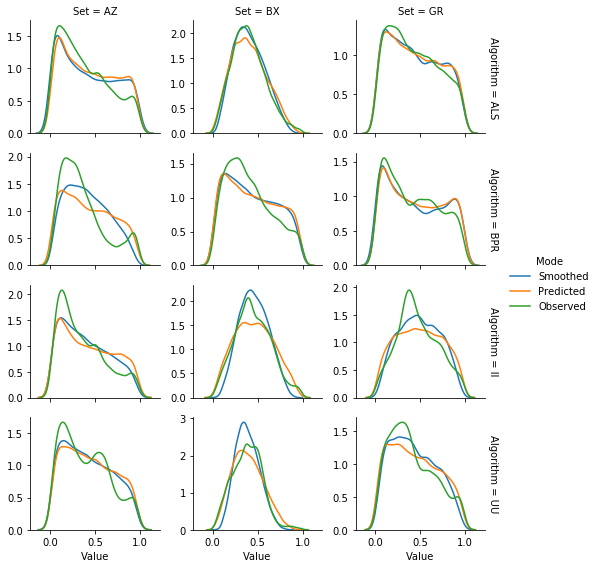

In [28]:
grid = sns.FacetGrid(col='Set', row='Algorithm', hue='Mode',
                     data=select_implicit(bias_data),
                     sharey=False, aspect=1.2, height=2, margin_titles=True)
grid.map(sns.kdeplot, 'Value', clip=(0,1)).add_legend()
#plt.savefig(fig_dir / 'rec-implicit-dense.pdf')

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\RecModel\rec-implicit-dense.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_density : Removed 442 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_density : Removed 442 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


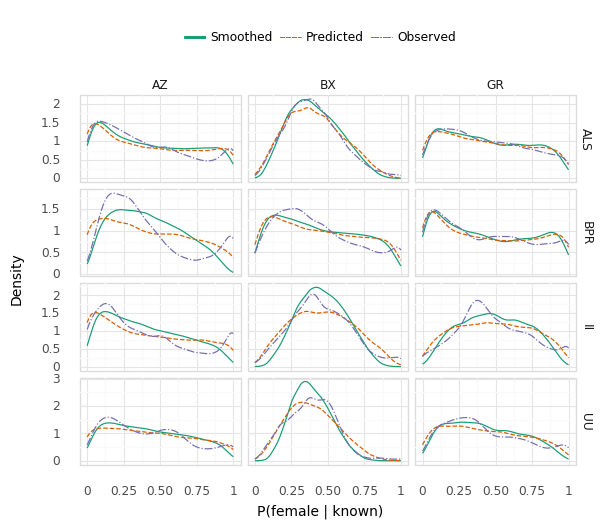

<ggplot: (-9223371883673502904)>

In [29]:
make_plot(select_implicit(bias_data), aes('Value', color='Mode', linetype='Mode'),
          geom_line(stat='density', bw='scott', clip=(0,1)),
          scale_color_brewer('qual', 'Dark2'),
          facet_grid('Algorithm ~ Set', scales='free_y'),
          xlab('P(female | known)'), ylab('Density'),
          legend_position='top', legend_title=element_blank(),
          file='rec-implicit-dense.pdf', width=8, height=7)

And the **explicit** runs:

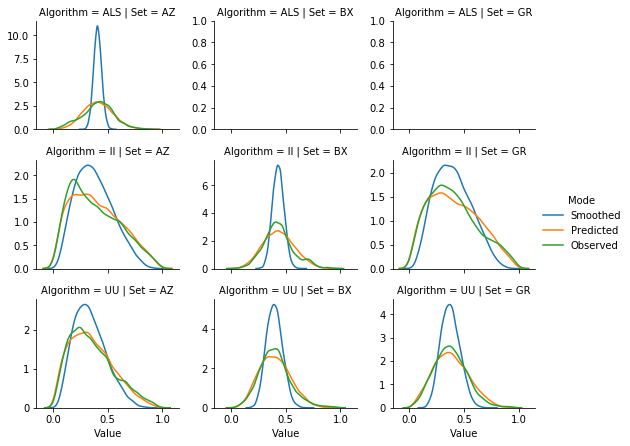

In [30]:
grid = sns.FacetGrid(col='Set', row='Algorithm', hue='Mode',
                     data=select_explicit(bias_data),
                     sharey=False, aspect=1.2, height=2.1)
grid.map(sns.kdeplot, 'Value', clip=(0,1)).add_legend()
# plt.savefig(fig_dir / 'rec-explicit-dense.pdf')

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 5.5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\RecModel\rec-explicit-dense.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_density : Removed 495 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_density : Removed 495 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


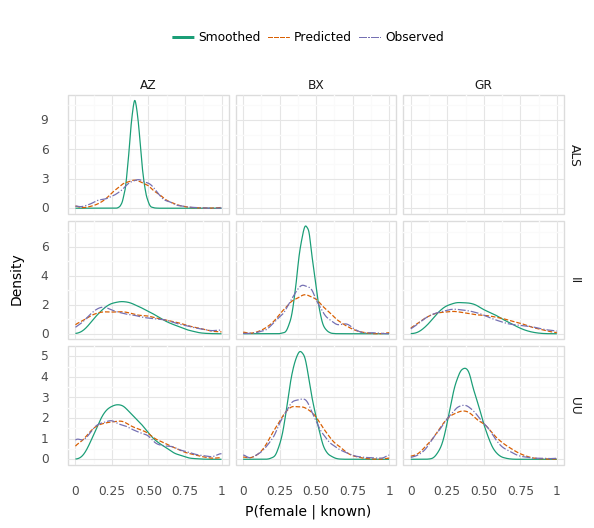

<ggplot: (-9223371883666116284)>

In [31]:
make_plot(select_explicit(bias_data), aes('Value', color='Mode', linetype='Mode'),
          geom_line(stat='density', bw='scott', clip=(0,1)),
          scale_color_brewer('qual', 'Dark2'),
          facet_grid('Algorithm ~ Set', scales='free_y'),
          xlab('P(female | known)'), ylab('Density'),
          legend_position='top', legend_title=element_blank(),
          file='rec-explicit-dense.pdf', width=8, height=5.5)

## Examining Regression Parameters

In [32]:
params = pd.DataFrame({
    'Intercept': algo_samples('recB').mean(axis=1),
    'Slope': algo_samples('recS').mean(axis=1),
    'Variance': algo_samples('recV').mean(axis=1)
})
params.head()

Intercept     Slope  Variance
Set Algorithm                                   
AZ  als            -0.340491  0.083791  0.328336
    bpr-imp        -0.146189  0.670103  1.014717
    item-item      -0.387291  0.443457  0.750479
    item-item-imp  -0.234058  0.816541  1.017666
    user-user      -0.582126  0.393953  0.542325

In [33]:
param_samples = pd.DataFrame({
    'Intercept': algo_samples('recB').stack(),
    'Slope': algo_samples('recS').stack(),
    'Variance': algo_samples('recV').stack()
})
param_samples.head()

Intercept     Slope  Variance
Set Algorithm Sample                               
AZ  als       0       -0.328758  0.082821  0.336611
              1       -0.354913  0.089185  0.338734
              2       -0.324114  0.079276  0.327507
              3       -0.356042  0.089567  0.336598
              4       -0.320088  0.088707  0.326246

In [34]:
def reg_ints(df):
    return pd.Series({
        'I_mean': df.Intercept.mean(),
        'I_lo': df.Intercept.quantile(0.025),
        'I_hi': df.Intercept.quantile(0.975),
        'S_mean': df.Slope.mean(),
        'S_lo': df.Slope.quantile(0.025),
        'S_hi': df.Slope.quantile(0.975)
    })

### Implicit Parameters

What are the **implicit** parameters?

In [35]:
select_implicit(params).pivot(index='Algorithm', columns='Set', values=['Intercept', 'Slope', 'Variance'])

Intercept                         Slope                      \
Set              AZ        BX        GR        AZ        BX        GR   
Algorithm                                                               
ALS       -0.027693 -0.108817 -0.049088  1.033563  0.740594  1.123110   
BPR       -0.146189  0.244671 -0.006430  0.670103  1.397094  1.353026   
II        -0.234058  0.100294  0.144656  0.816541  0.663158  0.782817   
UU        -0.074513 -0.260962 -0.146916  0.807061  0.544738  0.900435   

           Variance                      
Set              AZ        BX        GR  
Algorithm                                
ALS        0.591941  0.248550  0.403823  
BPR        1.014717  0.489751  0.657851  
II         1.017666  0.629764  0.682126  
UU         0.508239  0.414250  0.652005

In [36]:
imp_recB = select_implicit(algo_samples('recB')).set_index(['Set', 'Algorithm'])
imp_recS = select_implicit(algo_samples('recS')).set_index(['Set', 'Algorithm'])
imp_recV = select_implicit(algo_samples('recV')).set_index(['Set', 'Algorithm'])
imp_ds = imp_recB.index.levels[0]
imp_as = imp_recB.index.levels[1]

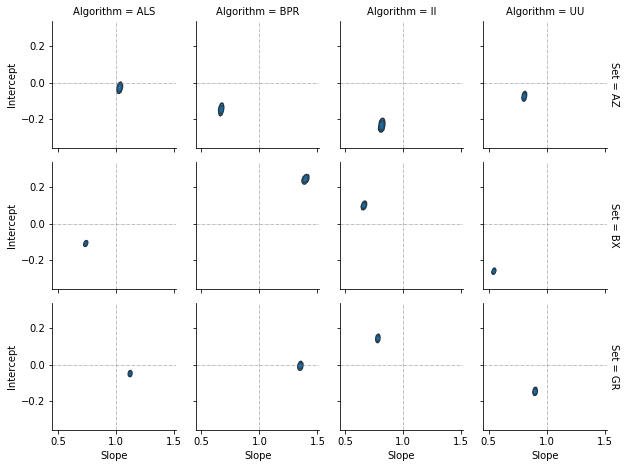

In [37]:
grid = sns.FacetGrid(col='Algorithm', row='Set', data=select_implicit(param_samples), margin_titles=True, height=2.2)
def _si_kde(*args, **kwargs):
    plt.axhline(0, 0, 1, ls='-.', lw=0.5, color='grey')
    plt.axvline(1, 0, 1, ls='-.', lw=0.5, color='grey')
    sns.kdeplot(*args, levels=5, **kwargs)
grid.map(_si_kde, 'Slope', 'Intercept')
plt.savefig(fig_dir / 'reg-param-implicit.pdf')

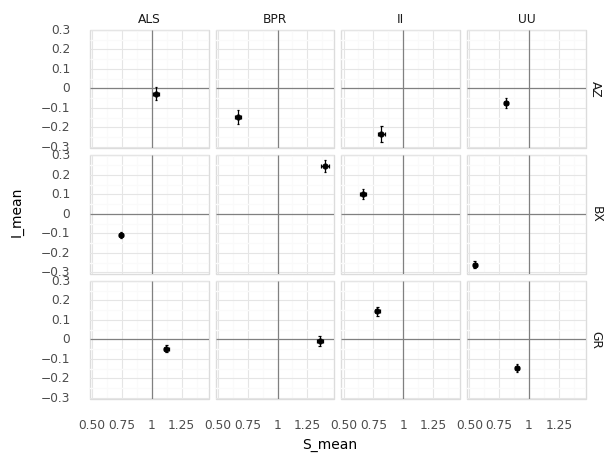

<ggplot: (-9223371883668829736)>

In [38]:
imp_cis = select_implicit(param_samples).groupby(['Set', 'Algorithm']).apply(reg_ints)
make_plot(imp_cis.reset_index(),
          aes(x='S_mean', xmin='S_lo', xmax='S_hi',
              y='I_mean', ymin='I_lo', ymax='I_hi'),
          geom_hline(yintercept=0, color='grey'),
          geom_vline(xintercept=1, color='grey'),
          geom_point(),
          geom_errorbar(width=0.02),
          geom_errorbarh(height=0.02),
          facet_grid('Set ~ Algorithm'))

### Explicit Parameters

What are the **explicit** parameters?

In [39]:
select_explicit(params).pivot(index='Algorithm', columns='Set', values=['Intercept', 'Slope', 'Variance'])

Intercept                         Slope                      \
Set              AZ        BX        GR        AZ        BX        GR   
Algorithm                                                               
ALS       -0.340491       NaN       NaN  0.083791       NaN       NaN   
II        -0.387291 -0.212710 -0.317493  0.443457  0.179691  0.516601   
UU        -0.582126 -0.328594 -0.453174  0.393953  0.261387  0.251959   

           Variance                      
Set              AZ        BX        GR  
Algorithm                                
ALS        0.328336       NaN       NaN  
II         0.750479  0.440786  0.756335  
UU         0.542325  0.400198  0.447635

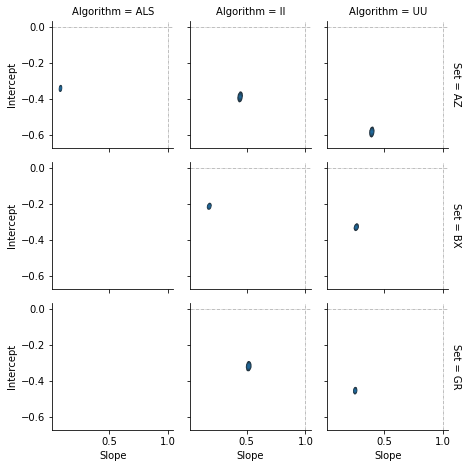

In [40]:
grid = sns.FacetGrid(col='Algorithm', row='Set', data=select_explicit(param_samples), margin_titles=True, height=2.2)
def _si_kde(*args, **kwargs):
    plt.axhline(0, 0, 1, ls='-.', lw=0.5, color='grey')
    plt.axvline(1, 0, 1, ls='-.', lw=0.5, color='grey')
    sns.kdeplot(*args, levels=5, **kwargs)
grid.map(_si_kde, 'Slope', 'Intercept')
plt.savefig(fig_dir / 'reg-param-explicit.pdf')

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_errorbar : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_errorbarh : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


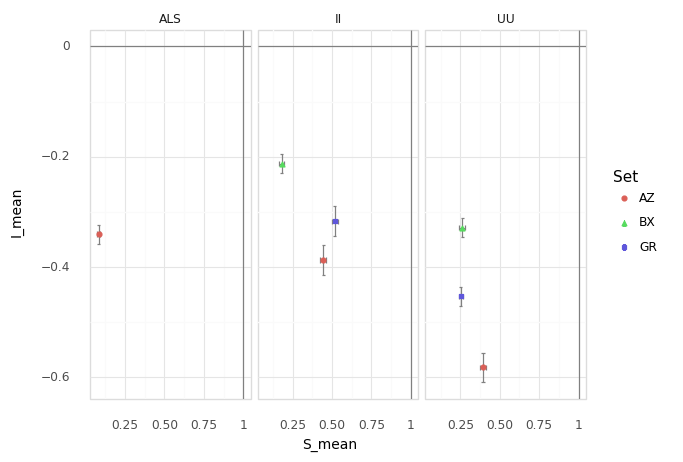

<ggplot: (-9223371883673577880)>

In [41]:
exp_cis = select_explicit(param_samples).groupby(['Set', 'Algorithm']).apply(reg_ints)
make_plot(exp_cis.reset_index(),
          aes(x='S_mean', xmin='S_lo', xmax='S_hi',
              y='I_mean', ymin='I_lo', ymax='I_hi'),
          geom_hline(yintercept=0, color='grey'),
          geom_vline(xintercept=1, color='grey'),
          geom_errorbar(width=0.02, color='grey'),
          geom_errorbarh(height=0.01, color='grey'),
          geom_point(aes(color='Set', shape='Set')),
          facet_grid('~ Algorithm'))

### Integrated Plots

Let's try to put these parameter plots into a single display.

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\RecModel\reg-params-all.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_errorbar : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_errorbarh : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_errorbar : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_errorbarh : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


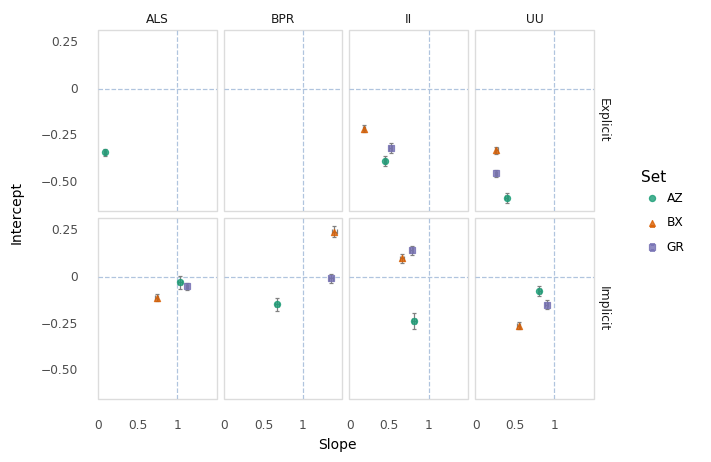

<ggplot: (-9223371883673489700)>

In [42]:
param_conf = pd.concat({
    'Explicit': exp_cis.reset_index().astype({'Algorithm': 'str'}),
    'Implicit': imp_cis.reset_index().astype({'Algorithm': 'str'})
}, names=['Mode'])
make_plot(param_conf.reset_index(),
          aes(x='S_mean', xmin='S_lo', xmax='S_hi',
              y='I_mean', ymin='I_lo', ymax='I_hi'),
          geom_hline(yintercept=0, color='lightsteelblue', linetype='dashed'),
          geom_vline(xintercept=1, color='lightsteelblue', linetype='dashed'),
          geom_errorbar(width=0.05, color='grey'),
          geom_errorbarh(height=0.03, color='grey'),
          geom_point(aes(color='Set', shape='Set'), size=2, alpha=0.8),
          facet_grid('Mode ~ Algorithm'),
          scale_color_brewer('qual', 'Dark2'),
          xlab('Slope'), ylab('Intercept'),
          file='reg-params-all.pdf', width=8, height=5,
          panel_grid=element_blank())

## Plotting Regressions

Let's plot those regressions.

### Implicit Feedback

We will start with **implicit** data:

In [43]:
imp_points = pd.merge(
    select_implicit(profiles)[['Set', 'user', 'PropFemale']],
    select_implicit(rec_lists)[['Set', 'Algorithm', 'user', 'Bias']]
).set_index(['Set', 'Algorithm', 'user'])
imp_points.head()

PropFemale      Bias
Set Algorithm user                      
AZ  BPR       529     0.800000  0.466667
    II        529     0.800000  0.777778
    UU        529     0.800000  0.685714
    ALS       529     0.800000  0.785714
    BPR       1723    0.285714  0.270833

In [44]:
imp_params = select_implicit(params).set_index(['Set', 'Algorithm'])
xs = np.linspace(0, 1, 201)
imp_curves = np.outer(imp_params['Slope'], logit(xs))
imp_curves = imp_curves + imp_params['Intercept'].values.reshape((len(imp_params), 1))
imp_curves = expit(imp_curves)
imp_curves = pd.DataFrame(imp_curves, index=imp_params.index, columns=xs)
imp_curves.columns.name = 'x'
imp_curves = imp_curves.stack().reset_index(name='y')
imp_curves

,Set,Algorithm,x,y
0,AZ,BPR,0.000,0.000000
1,AZ,BPR,0.005,0.024286
2,AZ,BPR,0.010,0.038221
3,AZ,BPR,0.015,0.049722
4,AZ,BPR,0.020,0.059855
...,...,...,...,...
2407,GR,ALS,0.980,0.986899
2408,GR,ALS,0.985,0.990535
2409,GR,ALS,0.990,0.994010
2410,GR,ALS,0.995,0.997257


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\RecModel\rec-scatter-imp.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


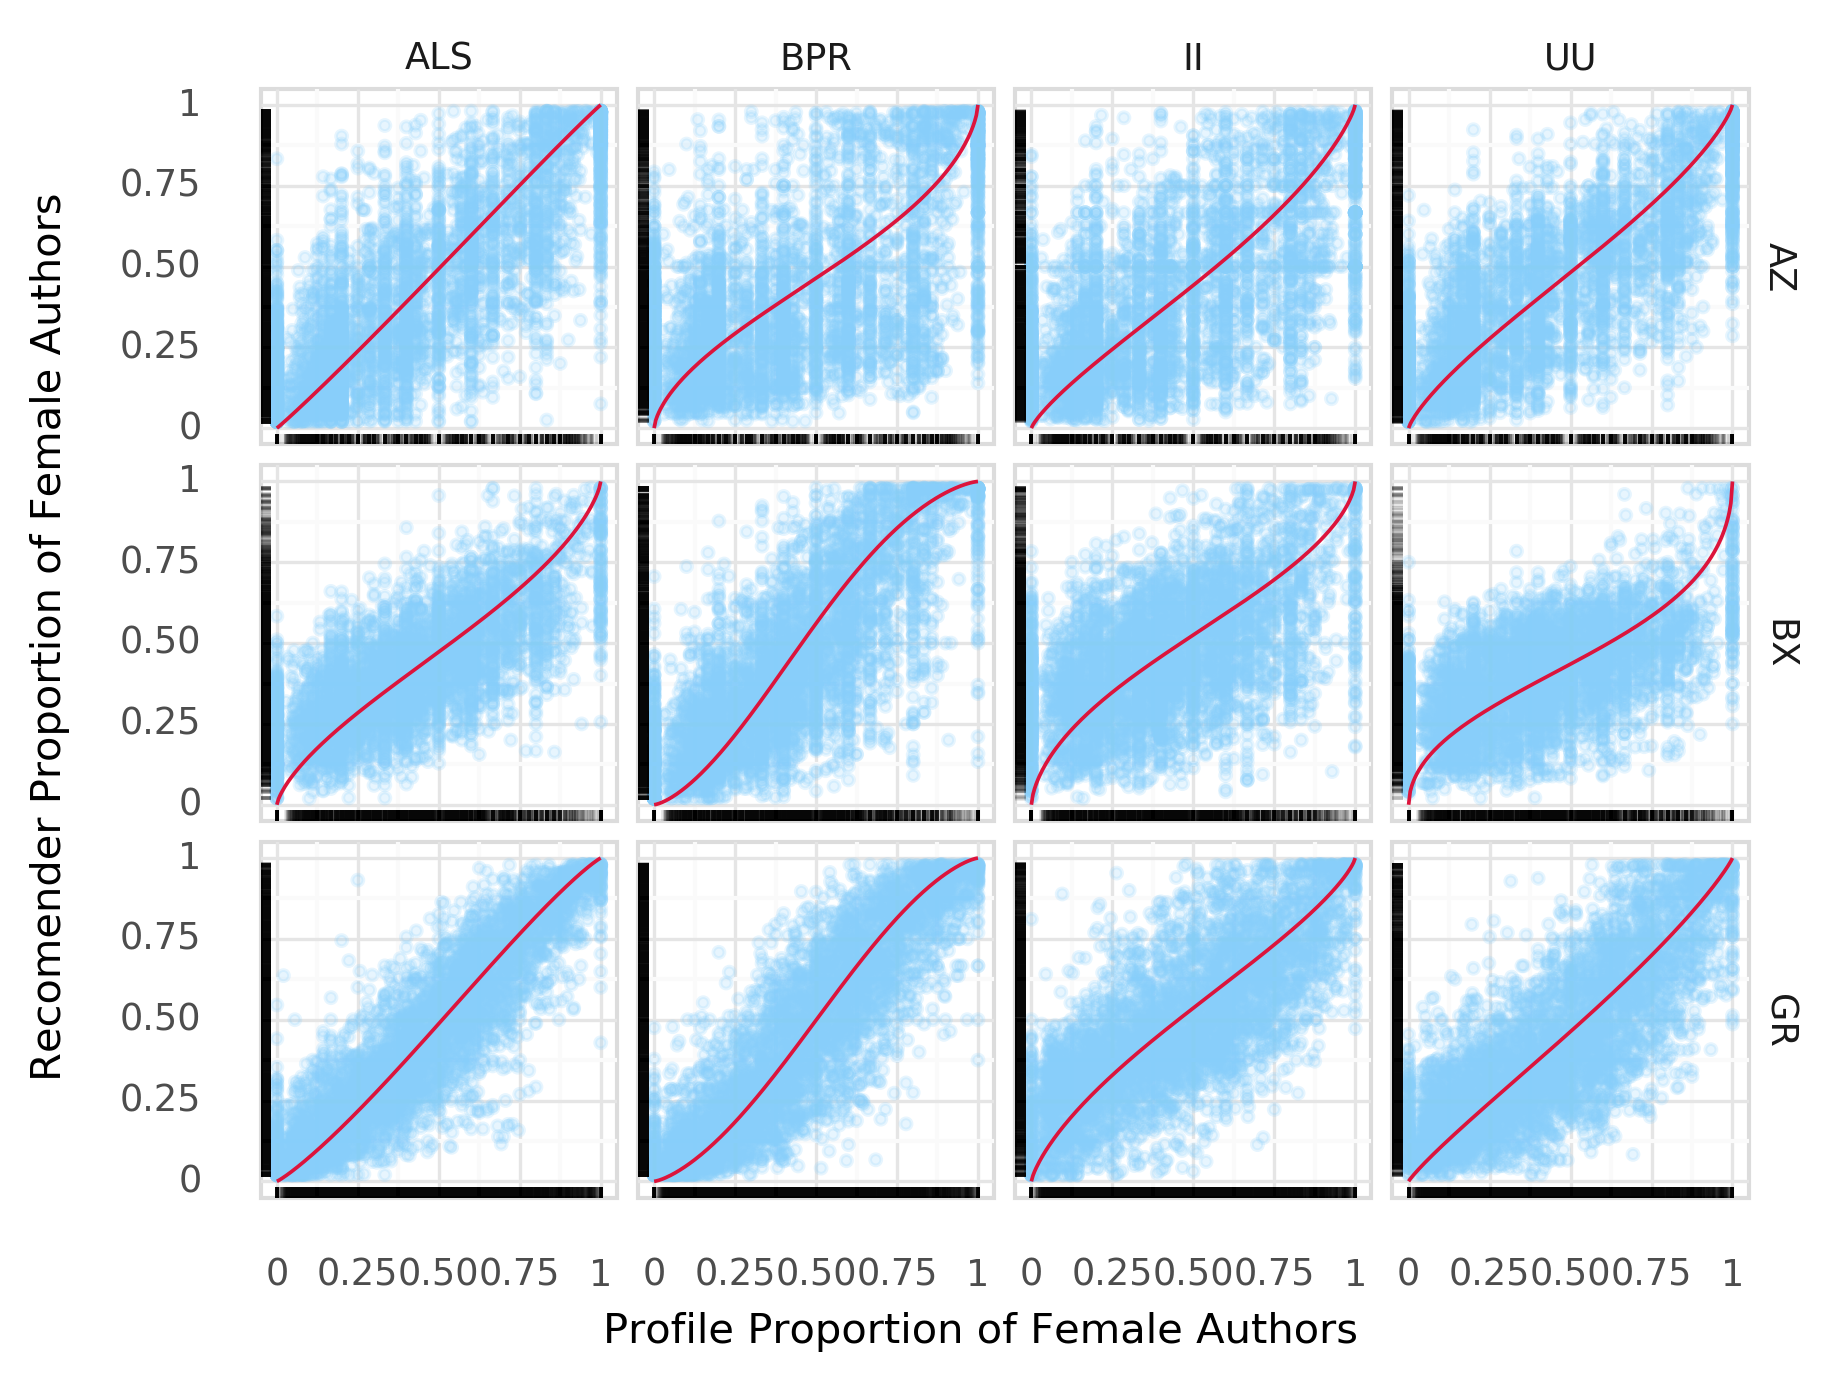

<ggplot: (-9223371883674989264)>

In [45]:
make_plot(imp_points.reset_index(),
          aes('PropFemale', 'Bias'),
          geom_point(alpha=0.2, color='lightskyblue', size=1),
          geom_rug(alpha=0.1),
          geom_line(aes('x', 'y'), imp_curves, color='crimson'),
          facet_grid('Set ~ Algorithm'),
          xlab('Profile Proportion of Female Authors'),
          ylab('Recomender Proportion of Female Authors'),
          file='rec-scatter-imp.png', width=8, height=7, dpi=300)

### Explicit Feedback

And the **explicit** data:

In [46]:
exp_points = pd.merge(
    select_explicit(profiles)[['Set', 'user', 'PropFemale']],
    select_explicit(rec_lists)[['Set', 'Algorithm', 'user', 'Bias']]
).set_index(['Set', 'Algorithm', 'user'])
exp_points.head()

PropFemale      Bias
Set Algorithm user                      
AZ  ALS       529     0.800000  0.310345
    II        529     0.800000  0.666667
    UU        529     0.800000  0.551724
    ALS       1723    0.285714  0.565217
    II        1723    0.285714  0.500000

In [47]:
exp_params = select_explicit(params).set_index(['Set', 'Algorithm'])
xs = np.linspace(0, 1, 201)
exp_curves = np.outer(exp_params['Slope'], logit(xs))
exp_curves = exp_curves + exp_params['Intercept'].values.reshape((len(exp_params), 1))
exp_curves = expit(exp_curves)
exp_curves = pd.DataFrame(exp_curves, index=exp_params.index, columns=xs)
exp_curves.columns.name = 'x'
exp_curves = exp_curves.stack().reset_index(name='y')
exp_curves

,Set,Algorithm,x,y
0,AZ,ALS,0.000,0.000000
1,AZ,ALS,0.005,0.313454
2,AZ,ALS,0.010,0.326179
3,AZ,ALS,0.015,0.333784
4,AZ,ALS,0.020,0.339261
...,...,...,...,...
1402,GR,UU,0.980,0.628878
1403,GR,UU,0.985,0.645924
1404,GR,UU,0.990,0.669208
1405,GR,UU,0.995,0.706930


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 5.5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\RecModel\rec-scatter-exp.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


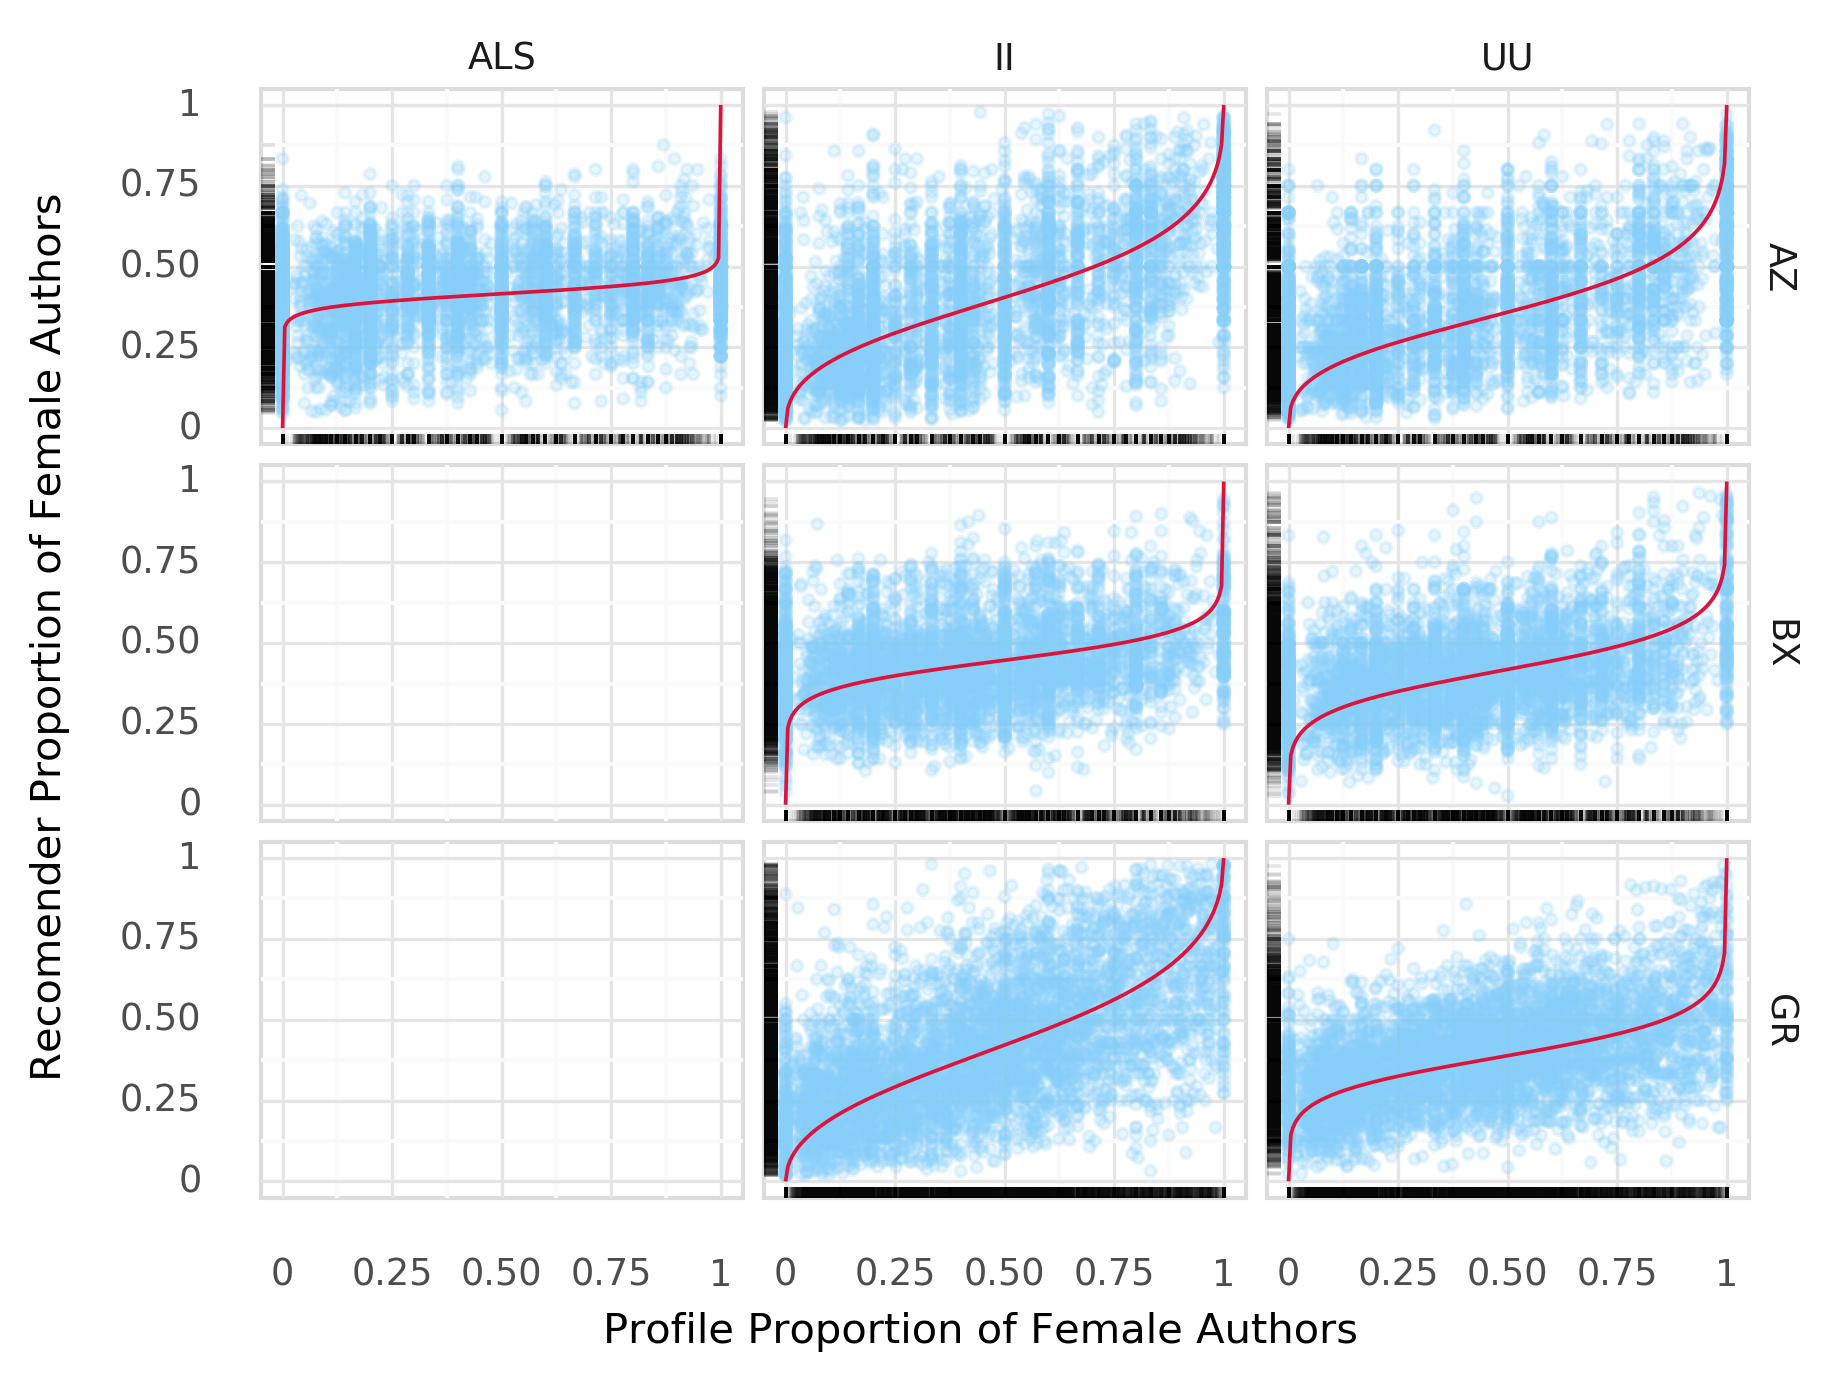

<ggplot: (-9223371883650740552)>

In [48]:
make_plot(exp_points.reset_index(),
          aes('PropFemale', 'Bias'),
          geom_point(alpha=0.2, color='lightskyblue', size=1),
          geom_rug(alpha=0.1),
          geom_line(aes('x', 'y'), exp_curves, color='crimson'),
          facet_grid('Set ~ Algorithm'),
          xlab('Profile Proportion of Female Authors'),
          ylab('Recomender Proportion of Female Authors'),
          file='rec-scatter-exp.png', width=8, height=5.5, dpi=300)